In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from lxml import etree as ET
import cv2 as cv
from shutil import copy
import os

for files in os.listdir('../input/face-mask-detection'):
    print(files)

annotations
images


In [2]:
def get_objects(file_path):
    
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    var_list = []

    for obj in root.iter(['name','xmin','ymin','xmax','ymax']):
        var_list.append(obj.text)
    
    return var_list
        

In [3]:
xml_path = '../input/face-mask-detection/annotations'
xml_files = sorted(os.listdir(xml_path))

objects = []

for file in xml_files:
    path = xml_path + '/' + file
    objects.append(get_objects(path))

print("Objects of first XML File :\n")
print(objects[0])

Objects of first XML File :

['without_mask', '79', '105', '109', '142', 'with_mask', '185', '100', '226', '144', 'without_mask', '325', '90', '360', '141']


In [4]:
root_file = '/kaggle/working/images'
with_mask = '/kaggle/working/images/with_mask'
without_mask = '/kaggle/working/images/without_mask'
mask_weared_incorrect = '/kaggle/working/images/mask_weared_incorrect'


try:
    os.mkdir(root_file)
    
except FileExistsError:
    print('Directory already Exists')
    
try:
    os.mkdir(with_mask)
    
except FileExistsError:
    print('Directory already Exists')

try:
    os.mkdir(without_mask)
    
except FileExistsError:
    print('Directory already Exists')
    
try:
    os.mkdir(mask_weared_incorrect)
    
except FileExistsError:
    print('Directory already Exists')


In [5]:
print(objects[0])

['without_mask', '79', '105', '109', '142', 'with_mask', '185', '100', '226', '144', 'without_mask', '325', '90', '360', '141']


In [6]:
def crop_and_copy_images(img_path,objects):
    
    root_path = './images'
    img_dir_path = '../input/face-mask-detection/images'
    
    cnt =0 
    
    for i in range(len(img_path)):
        image_file_path = img_dir_path + '/' + img_path[i]
        img = cv.imread(image_file_path)
        img = cv.cvtColor(img,cv.COLOR_RGB2BGR)
        
        for j in range(len(objects[i])//5):
            
            category = objects[i][j*5]
                
            x1 = int(objects[i][j*5+1])
            y1 = int(objects[i][j*5+2])
            x2 = int(objects[i][j*5+3])
            y2 = int(objects[i][j*5+4])
            
            crop = img[y1:y2,x1:x2]
            cnt+=1
            path = os.path.join(root_path,category,'img'+str(cnt)+'.png')
            cv.imwrite(path,crop)

In [7]:
img_dir_path = '../input/face-mask-detection/images'
img_file_path = sorted(os.listdir(img_dir_path))

crop_and_copy_images(img_file_path,objects)

In [8]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten

In [9]:
datagen = ImageDataGenerator(rescale=1/255,
                             brightness_range = [0.5,1.0],
                             zoom_range  = 0.1,
                             horizontal_flip = True,
                             validation_split=0.10,
                             shear_range=0.05
                            )

train_gen = datagen.flow_from_directory(
                                    './images',
                                    target_size=(128,128),
                                    subset ='training'
    
)

val_gen = datagen.flow_from_directory(
    './images',
    target_size=(128,128),
    subset ='validation'
    
)

Found 3666 images belonging to 3 classes.
Found 406 images belonging to 3 classes.


In [10]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5
)

In [11]:
model = keras.Sequential([Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
                          Conv2D(32,(3,3),activation='relu'),
                          MaxPooling2D(2,2),
                          Conv2D(64,(3,3),activation='relu'),
                          Conv2D(64,(3,3),activation='relu'),
                          Conv2D(64,(5,5),padding='same',activation='relu'),
                          MaxPooling2D(2,2),
                          Conv2D(128,(3,3),activation='relu'),
                          Conv2D(128,(5,5),padding='same',activation='relu'),
                          MaxPooling2D(2,2),
                          Conv2D(256,(5,5),activation='relu'),
                          Dropout(0.4),
                          Flatten(),
                          Dense(256,activation='relu'),
                          Dense(3,activation='softmax')
                         ])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history= model.fit(train_gen,validation_data=val_gen,epochs=20,callbacks=[es])

Epoch 1/20
115/115 [==============================] - 26s 195ms/step - loss: 0.9256 - accuracy: 0.7212 - val_loss: 0.2447 - val_accuracy: 0.9039
Epoch 2/20
115/115 [==============================] - 21s 183ms/step - loss: 0.2299 - accuracy: 0.9351 - val_loss: 0.2186 - val_accuracy: 0.9212
Epoch 3/20
115/115 [==============================] - 22s 189ms/step - loss: 0.2006 - accuracy: 0.9349 - val_loss: 0.2287 - val_accuracy: 0.9236
Epoch 4/20
115/115 [==============================] - 22s 190ms/step - loss: 0.1994 - accuracy: 0.9339 - val_loss: 0.2370 - val_accuracy: 0.9138
Epoch 5/20
115/115 [==============================] - 21s 184ms/step - loss: 0.1939 - accuracy: 0.9393 - val_loss: 0.2097 - val_accuracy: 0.9335
Epoch 6/20
115/115 [==============================] - 22s 188ms/step - loss: 0.2145 - accuracy: 0.9309 - val_loss: 0.2493 - val_accuracy: 0.9187
Epoch 7/20
115/115 [==============================] - 21s 186ms/step - loss: 0.2065 - accuracy: 0.9413 - val_loss: 0.2151 - val_ac

Text(0.5, 1.0, 'Loss vs Epochs')

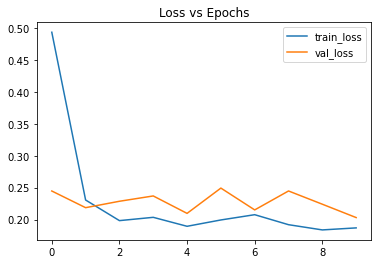

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss,label = 'train_loss')
plt.plot(val_loss,label = 'val_loss')
plt.legend()
plt.title('Loss vs Epochs')

Text(0.5, 1.0, 'Accuracy vs Epochs')

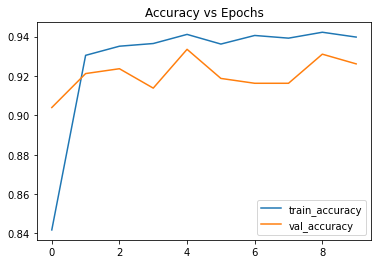

In [13]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc,label = 'train_accuracy')
plt.plot(val_acc,label = 'val_accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

In [14]:
model.save('mask_detection.h5')

In [ ]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

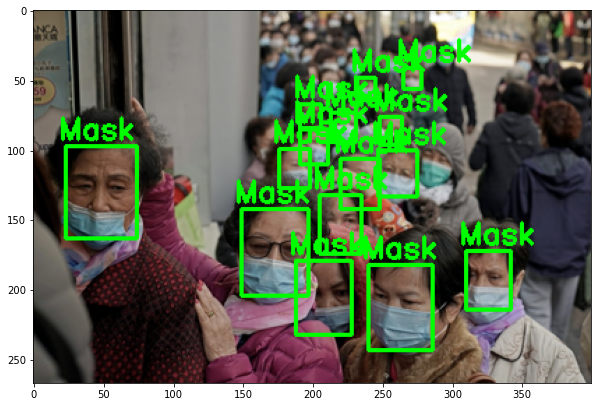

In [67]:
detector = MTCNN()

img = cv.imread('../input/face-mask-detection/images/maksssksksss3.png')
img = cv.cvtColor(img,cv.COLOR_RGB2BGR)

faces = detector.detect_faces(img)

for face in faces:
    
    x,y,w,h = face['box']
    
    crop = img[y:y+h,x:x+w]
    crop = cv.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    yhat = model.predict_classes(crop)

    if yhat ==1 or y==0:
        color = (0,255,0)
        label ='Mask'

    elif y==2:
        color = (0,0,255)
        label = 'No Mask'
        
    
    cv.rectangle(img,(x,y),(x+w,y+h),color,2)
    cv.putText(img,label,(x-5,y-5),cv.FONT_HERSHEY_SIMPLEX,0.7,color,2)

plt.figure(figsize=(10,10))
plt.imshow(img)